<center> <a href = Languages.ipynb>Language Use &lt;</a> | <a href = Organization.ipynb>&gt; Notebook Organization</a> </center>

# Owners
This notebook looks at what types of owners (user, organization, educational, personal, and enterprise) have public notebooks on GitHub.

## Results Summary:
- 4.72% of all owners are organizations; they own 7.86% of notebooks.
- 25.82% of notebook owners only have one notebook on GitHub. 23.89% of notebook owners have over 10 notebooks on GitHub
- 54.13% of repositories have a description.
- Users have an average of 10.88 notebooks on GitHub (Median = 4). Organizations have an average of 19.03 notebooks on GitHub (Median = 4).
- 23.34% of repos with descriptions are educational. These repositories hold 28.564% of notebooks.
- 16.27% of individual users have primarily educational repositories while 18.12% of organizational users have primarily educational repositories.
- Educational owners tend to host more notebooks (mean 9.67, median 4) compared to non-educational owners (mean 8.61, median 3)

----

# Import Packages & Load Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

import load_data
import datetime
import pickle

In [2]:
notebooks = load_data.load_notebooks()
repos = load_data.load_repos()
owners = load_data.load_owners()


Notebooks loaded in 0:00:27.213445
Repos loaded in 0:00:04.234616
Owners loaded in 0:00:01.273735


--------

# Manipulate Data

## Separate types of owners: organizations vs users

In [3]:
users = owners[owners.type == 'User']
orgs = owners[owners.type == 'Organization']

In [4]:
user_nbs = notebooks[notebooks.owner_id.isin(users.owner_id)]
org_nbs = notebooks[notebooks.owner_id.isin(orgs.owner_id)]

## Identify educational owners
Define educational owners as owners whos repositories are primarily educational.
Define an educational repository as one that uses at least one of the educational words listed below. We are only considering repositories with descriptions as eligible.

### Isolate educational repositories

In [5]:
edu_words = [
    'teach', 'bootcamp', 'boot camp', 'capstone',
    'final project', 'thesis', 'demonstrat', 'workshop',
    'lesson', 'course', 'classroom', 'study', 'class ',         # space to avoid matching 'classification'
    'research', 'university', 'curriculum', 'udemy',
    'udacity', 'coursea', 'mit ', 'exercise',
    'example', 'instruction', 'tutorial', 'education',
    'student', 'assignment', 'homework',  'problem set', 'lecture'
]

Limit to repositories with descriptions.

In [6]:
repos_has_desc = repos.copy()[~repos.repo_description.isna()]
print("{0}% of repositories have a description.".format(round(
    100*len(repos_has_desc)/ len(repos), 2
)))

54.13% of repositories have a description.


Separate repositories with at least one educational word from those without.

In [7]:
repos_has_desc['edu_word_count'] = [
    sum([1 if 
         re.search('(?<![a-zA-Z]){0}'.format(e), str(r).lower()) 
         else 0 for e in edu_words]) 
    for r in repos_has_desc.repo_description
]
edu_repos = repos_has_desc.copy()[repos_has_desc['edu_word_count']>=1]
non_edu_repos = repos_has_desc.copy()[repos_has_desc['edu_word_count']==0]

edu_notebooks = notebooks.copy()[notebooks.repo_id.isin(edu_repos.repo_id)]
non_edu_notebooks = notebooks.copy()[notebooks.repo_id.isin(non_edu_repos.repo_id)]

### Visually inspect a sample of educational repos. Did we get them right?

Most of these descriptions seem to represent educational repositories, held by students and instructors alike.

These ones don't seem to fit: "How to handle emoji in Python + a quick Python script to count emoji in Tweets as an example. (python 2.7)", "This is a webcrawler which gets lists of articles from Korea University Library site."

In [8]:
print(
    edu_repos['repo_description'].sample(
        10, random_state = 50
    ).values
)

['All assignments and projects for my Deep Learning class.'
 'Data-Wrangling-Udacity'
 'pandaspart4and5-onwardmahachi created by GitHub Classroom'
 'Multilayer Perceptron Nerual Network example'
 'A basic tutorials on how to start-up the prediction of housing prices. '
 'CSCI 599 deep learning and its applications final project'
 'Repository for my code as I follow the  Stanford course Tensorflow for Deep Learning Research'
 '2nd assignment of image processing. Enhancing input images using a series of operations.'
 'API Homework' 'Session 2 Assignment']


### Visually inspect a sample of non-educational repos

Some repos are described in other languages, so this simple word-based check did not caputre them.
- "和Python相关的学习笔记：机器学习、算法、进阶书籍、文档，博客地址"
    - translation: "Python-related study notes: machine learning, algorithms, advanced books, documentation"
    
Other repos may be educational, but not for sure.
- "Intro to Biomedical Computational Programming"
- "AM221 PSet"
- "Experimental physics modules III, IV & V - Thimo Preis"

In [9]:
print(
    non_edu_repos['repo_description'].sample(
        10, random_state = 50
    ).values
)

['Successfully navigate a vehicle safely and smoothly through a track in simulator using MPC'
 'CLASSIFYING IMAGES OF NUMERICAL PHYSICAL SIGN LANGUAGE NUMBERS WITH MACHINE LEANING AND DIMENSIONALITY REDUCTION'
 'medical prediction stroke'
 'This is the famous titanic challenge to determine the survivors of titanic passengers'
 'parking lot for random colab projects'
 'ILP and SAT based attractor analysis in biological networks'
 'ART: A Reconstruction Tool. For reconstructing probability distributions using Gaussian processes.'
 'ML, Django and backend python modules of SmartAgro'
 'Detecting car makes and models using deep learning models.'
 'Mandel Lab Training']


In [10]:
repo_edu_status = pd.DataFrame({
    'repo_id': list(edu_repos.repo_id) + list(non_edu_repos.repo_id),
    'edu': [True]*len(edu_repos) + [False]*len(non_edu_repos)
})

In [11]:
f = open('analysis_data/repo_edu_status.df','wb')
pickle.dump(repo_edu_status, f)
f.close()

### Most common words within each group of repositories

In [12]:
from nltk.corpus import stopwords 
stop = set(stopwords.words('english'))

In [13]:
print("Most common words in descriptions of educational repositories")
print("and the proportion of descriptions they appear in")
print("(excluding educational words we selected for)")
(pd.Series([
    w.lower() for w in ' '.join(edu_repos['repo_description']).split()
    if w.lower() not in stop and sum([w.lower() in e or e in w.lower() for e in edu_words]) == 0 and len(w) > 2
]).value_counts()/len(edu_repos))[:10]

Most common words in descriptions of educational repositories
and the proportion of descriptions they appear in
(excluding educational words we selected for)


learning      0.172002
data          0.171861
machine       0.099476
python        0.082572
created       0.081021
github        0.077514
science       0.069308
repository    0.069167
deep          0.065043
nanodegree    0.061094
dtype: float64

In [14]:
print("Most common words in descriptions of non-educational repositories")
(pd.Series([
    w.lower() for w in ' '.join(non_edu_repos['repo_description']).split()
    if w.lower() not in stop and len(w) > 2
]).value_counts()/len(non_edu_repos))[:10]

Most common words in descriptions of non-educational repositories


data          0.142275
using         0.106842
learning      0.103911
python        0.087586
project       0.071583
analysis      0.061888
machine       0.061418
code          0.043540
repository    0.034596
model         0.032602
dtype: float64

### Add repository type to repos dataframe

In [15]:
edu_repos['type'] = 'Educational'
non_edu_repos['type'] = 'Non-Educational'
repos = pd.concat([edu_repos, non_edu_repos])

### Determine if *owners* are educational or not

In [16]:
type_counts = repos.groupby(
    ['owner_id','type']
)['repo_id'].count().reset_index().pivot(
    index = 'owner_id', 
    columns = 'type', 
    values = 'repo_id'
).reset_index().fillna(0)

In [17]:
type_counts['owner_type'] = [
    'Educational' if r['Educational'] > r['Non-Educational']
    else ('Non-Educational' if r['Educational'] < r['Non-Educational']
         else '')
    for _, r in type_counts.iterrows()
]

In [18]:
type_counts = type_counts.merge(owners[['owner_id','type']], on = 'owner_id')
type_counts.head()

,owner_id,Educational,Non-Educational,owner_type,type
0,29,1.0,0.0,Educational,User
1,200,1.0,0.0,Educational,User
2,224,1.0,7.0,Non-Educational,User
3,224,1.0,7.0,Non-Educational,User
4,224,1.0,7.0,Non-Educational,User


---------

# Visualizations & Statistics

## Owner types

In [19]:
prop_user = len(user_nbs) / (len(user_nbs) + len(org_nbs))
prop_org = len(org_nbs) / (len(user_nbs) + len(org_nbs))
print("{0:,} ({1}%) of owners are organizations.".format(
    len(orgs), round(100*len(orgs)/(len(orgs) + len(users)),2),
))
print("{0}% of notebooks are owned by organizations, while {1}% are owned by users.".format(
    round(100*prop_org, 2), round(100*prop_user, 2)
))

34,664 (4.72%) of owners are organizations.
7.86% of notebooks are owned by organizations, while 92.14% are owned by users.


## Notebooks per Owner

In [20]:
nbs_per_owner = notebooks.groupby('owner_id')['file'].count().reset_index()

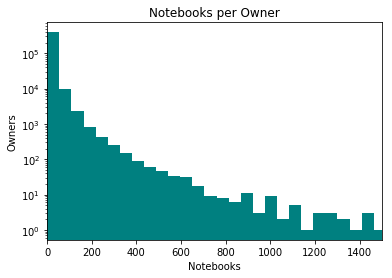

In [21]:
plt.hist(nbs_per_owner.file, bins = 500, color = 'teal')
plt.xlim(0, 1500)
plt.yscale('log')
plt.xlabel('Notebooks')
plt.ylabel('Owners')
plt.title('Notebooks per Owner')
plt.show()

In [22]:
print("{0}% of notebook owners only have one notebook on GitHub.".format(
    round(100*sum(nbs_per_owner.file == 1)/len(nbs_per_owner), 2)
))

print("{0}% of notebook owners have over 10 notebooks on GitHub".format(
    round(100*sum(nbs_per_owner.file > 10)/len(nbs_per_owner), 2)
))
print("Mean = {0}, Median = {1}, Range = {2}-{3}".format(
    round(nbs_per_owner.file.mean(), 2),
    nbs_per_owner.file.median(),
    nbs_per_owner.file.min(),
    nbs_per_owner.file.max()
))

25.82% of notebook owners only have one notebook on GitHub.
23.89% of notebook owners have over 10 notebooks on GitHub
Mean = 11.26, Median = 4.0, Range = 1-27085


## Notebooks per Owner: users vs organizations

In [23]:
print("For Users:")
user_nbs_per_owner = user_nbs.groupby('owner_id')['file'].count().reset_index()
print("{0}% of notebook owners only have one notebook on GitHub.".format(
    round(100*sum(user_nbs_per_owner.file == 1)/len(user_nbs_per_owner), 2)
))
print("{0}% of notebook owners have over 10 notebooks on GitHub".format(
    round(100*sum(user_nbs_per_owner.file > 10)/len(user_nbs_per_owner), 2)
))
print("Mean = {0}, Median = {1}".format(
    round(user_nbs_per_owner.file.mean(), 2),
    user_nbs_per_owner.file.median()
))

top_owner = owners[
    owners.owner_id == user_nbs_per_owner[
        user_nbs_per_owner.file==user_nbs_per_owner.file.max()
    ].owner_id.values[0]
].owner_html_url.values[0]
print('Top user: {0} with {1} notebooks.'.format(top_owner, user_nbs_per_owner.file.max()))

print("\nFor Organizations:")
org_nbs_per_owner = org_nbs.groupby('owner_id')['file'].count().reset_index()
print("{0}% of notebook owners only have one notebook on GitHub.".format(
    round(100*sum(org_nbs_per_owner.file == 1)/len(org_nbs_per_owner), 2)
))
print("{0}% of notebook owners have over 10 notebooks on GitHub".format(
    round(100*sum(org_nbs_per_owner.file > 10)/len(org_nbs_per_owner), 2)
))
print("Mean = {0}, Median = {1}".format(
    round(org_nbs_per_owner.file.mean(), 2),
    org_nbs_per_owner.file.median()
))

top_org = owners[
    owners.owner_id == org_nbs_per_owner[
        org_nbs_per_owner.file==org_nbs_per_owner.file.max()
    ].owner_id.values[0]
].owner_html_url.values[0]
print('Top organization: {0} with {1} notebooks.'.format(top_org, org_nbs_per_owner.file.max()))

For Users:
25.88% of notebook owners only have one notebook on GitHub.
23.7% of notebook owners have over 10 notebooks on GitHub
Mean = 10.88, Median = 4.0
Top user: https://github.com/gopala-kr with 2712 notebooks.

For Organizations:
24.75% of notebook owners only have one notebook on GitHub.
27.66% of notebook owners have over 10 notebooks on GitHub
Mean = 19.03, Median = 4.0
Top organization: https://github.com/learn-co-students with 27085 notebooks.


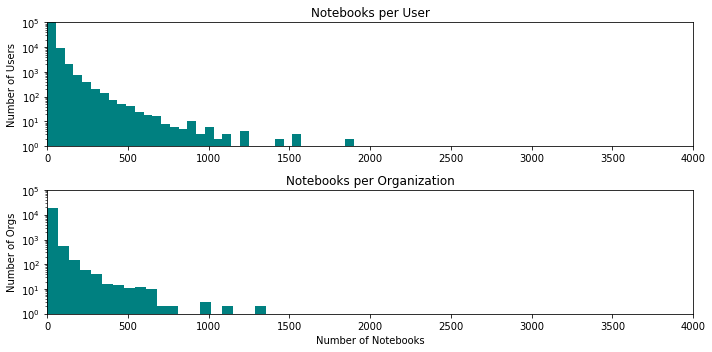

In [24]:
fig = plt.figure(figsize = (10, 5))

plt.subplot(2,1,1)
plt.hist(
    user_nbs_per_owner.file, 
    bins = 50,
    color='teal'
)
plt.title("Notebooks per User")
plt.ylabel("Number of Users")
plt.xlim(0, 4000)
plt.yscale('log')
plt.ylim(1, 100000)

plt.subplot(2,1,2)
plt.hist(
    org_nbs_per_owner.file, 
    bins = 400,
    color = 'teal'
)
plt.title("Notebooks per Organization")
plt.xlabel("Number of Notebooks")
plt.ylabel("Number of Orgs")
plt.xlim(0, 4000)
plt.yscale('log')
plt.ylim(1, 100000)

plt.tight_layout()
plt.show()

Both distributions are centered with a median at 4, but the range of number of notebooks is much wider for organizations and the average is much higher at 19.03 as opposed to 10.88.

## Educational owners versus non-educational owners

In [25]:
print("We've determined that {0}% of repos with descriptions (containing {1}% of notebooks in repos with descriptions) are educational.".format(
    round(100*len(edu_repos)/len(repos_has_desc), 2),
    round(100*len(edu_notebooks)/len(notebooks[notebooks.repo_id.isin(repos_has_desc.repo_id)]),3)
))

We've determined that 23.34% of repos with descriptions (containing 28.564% of notebooks in repos with descriptions) are educational.


In [26]:
num_edu_users = type_counts.owner_type.value_counts()['Educational']
num_non_edu_users = type_counts.owner_type.value_counts()['Non-Educational']
total_users = type_counts.owner_type.value_counts().sum()

print("{0}% of owners with at least one repo description are definitively educational or non-educational.".format(
    round(100*(num_edu_users + num_non_edu_users)/total_users, 2)
))
print("The other {0}% have equal numbers of educational and non-educational repositories".format(
    round(100-100*(num_edu_users + num_non_edu_users)/total_users, 2)
))
print("\nOf owners that are not split, {0}% are educational and {1}% are not.".format(
    round(100*(num_edu_users)/(num_edu_users + num_non_edu_users), 2),
    round(100*(num_non_edu_users)/(num_edu_users + num_non_edu_users), 2)

))

num_org_users = sum(type_counts.type == 'Organization')
num_indiv_users = sum(type_counts.type == 'User')
print("{0}% of individual users are educational while {1}% of organizational users are educational.".format(
    round(100*sum(np.logical_and(type_counts.type == 'User', type_counts.owner_type=='Educational'))/num_indiv_users, 2),
    round(100*sum(np.logical_and(type_counts.type == 'Organization', type_counts.owner_type=='Educational'))/num_org_users, 2),

))

93.53% of owners with at least one repo description are definitively educational or non-educational.
The other 6.47% have equal numbers of educational and non-educational repositories

Of owners that are not split, 17.5% are educational and 82.5% are not.
16.27% of individual users are educational while 18.12% of organizational users are educational.


## Notebooks per Owner: educational vs not

In [27]:
edu_nbs = notebooks[notebooks.repo_id.isin(edu_repos.repo_id)]
non_edu_nbs = notebooks[notebooks.repo_id.isin(non_edu_repos.repo_id)]

print("For Educational Owners:")
edu_nbs_per_owner = edu_nbs.groupby('owner_id')['file'].count().reset_index()
print("{0}% of educational owners only have one notebook on GitHub.".format(
    round(100*sum(edu_nbs_per_owner.file == 1)/len(edu_nbs_per_owner), 2)
))
print("{0}% of notebook owners have over 10 notebooks on GitHub".format(
    round(100*sum(edu_nbs_per_owner.file > 10)/len(edu_nbs_per_owner), 2)
))
print("Mean = {0}, Median = {1}".format(
    round(edu_nbs_per_owner.file.mean(), 2),
    edu_nbs_per_owner.file.median()
))

top_edu = owners[
    owners.owner_id == edu_nbs_per_owner[
        edu_nbs_per_owner.file==edu_nbs_per_owner.file.max()
    ].owner_id.values[0]
].owner_html_url.values[0]
print('Top educational owner: {0} with {1} notebooks.'.format(top_edu, edu_nbs_per_owner.file.max()))

print("\nFor Non-Educational Owners:")
non_edu_nbs_per_owner = non_edu_nbs.groupby('owner_id')['file'].count().reset_index()
print("{0}% of non-educational owners only have one notebook on GitHub.".format(
    round(100*sum(non_edu_nbs_per_owner.file == 1)/len(non_edu_nbs_per_owner), 2)
))
print("{0}% of non-educational owners have over 10 notebooks on GitHub".format(
    round(100*sum(non_edu_nbs_per_owner.file > 10)/len(non_edu_nbs_per_owner), 2)
))
print("Mean = {0}, Median = {1}".format(
    round(non_edu_nbs_per_owner.file.mean(), 2),
    non_edu_nbs_per_owner.file.median()
))

top_non_edu = owners[
    owners.owner_id == non_edu_nbs_per_owner[
        non_edu_nbs_per_owner.file==non_edu_nbs_per_owner.file.max()
    ].owner_id.values[0]
].owner_html_url.values[0]
print('Top non-educational owner: {0} with {1} notebooks.'.format(top_non_edu, non_edu_nbs_per_owner.file.max()))

For Educational Owners:
26.61% of educational owners only have one notebook on GitHub.
21.36% of notebook owners have over 10 notebooks on GitHub
Mean = 9.67, Median = 4.0
Top educational owner: https://github.com/MahopacHS with 2847 notebooks.

For Non-Educational Owners:
30.27% of non-educational owners only have one notebook on GitHub.
18.42% of non-educational owners have over 10 notebooks on GitHub
Mean = 8.61, Median = 3.0
Top non-educational owner: https://github.com/FOSSEE with 10343 notebooks.


## Number of notebooks per repository

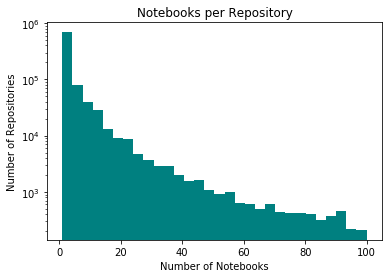

In [28]:
nbs_per_repo = notebooks.groupby('repo_id')['file'].count().reset_index().rename(columns = {'file':'num_nbs'})
plt.hist(nbs_per_repo.num_nbs[nbs_per_repo.num_nbs <= 100], bins = 30, color = 'teal')
plt.yscale('log')
plt.title('Notebooks per Repository')
plt.xlabel('Number of Notebooks')
plt.ylabel('Number of Repositories')
plt.show()

In [29]:
print("{0}% of repositories have only one notebook.".format(
    round(100*list(nbs_per_repo.num_nbs).count(1)/len(nbs_per_repo), 2)
))

print("{0}% of repositories have ten or more notebooks.".format(
    round(100*sum(nbs_per_repo.num_nbs >= 10)/len(nbs_per_repo), 2)
))

46.94% of repositories have only one notebook.
11.25% of repositories have ten or more notebooks.


<center> <a href = Languages.ipynb>Language Use &lt;</a> | <a href = Organization.ipynb>&gt; Notebook Organization</a> </center>